In [1]:
import json
import numpy as np
from typing import Optional
from pathlib import Path
from matplotlib import pyplot as plt

In [2]:
def load_experiments(results_path: Path, metadata_keys: list[str]) -> list[dict]:
    experiments = {}
    for i in range(0, 1000):
        try:
            experiment_path = results_path / f'experiment_{i}.json'
            experiment_file = open(experiment_path, 'r')
            experiment = json.load(experiment_file)

            metadata_path = results_path / f'experiment_{i}_metadata.json'
            metadata_file = open(metadata_path, 'r')
            metadata = json.load(metadata_file)

            _dict = experiments
            for key in metadata_keys[:-1]:
                value = metadata.get(key, None)
                _dict = _dict.setdefault((key, value), {})
            key = metadata_keys[-1]
            value = metadata.get(key, None)
            _dict.setdefault((key, value), list(experiment.items())) 
        except FileNotFoundError:
            break
    return experiments

In [3]:
results_path = Path('../../results')
metadata_keys = [
    'name',
    'qfa size',
    'qiskit circuit size',
    'simulator',
    'mimic_rate',
    'use_entropy_mapping',
    'use_mapping_noise_correction'
]
experiments = load_experiments(results_path, metadata_keys)
print(metadata_keys)
print(experiments[('name', 'mapping effect, QFA state number effect')])

['name', 'qfa size', 'qiskit circuit size', 'simulator', 'mimic_rate', 'use_entropy_mapping', 'use_mapping_noise_correction']
{('qfa size', 10): {('qiskit circuit size', 4): {('simulator', True): {('mimic_rate', 1): {('use_entropy_mapping', False): {('use_mapping_noise_correction', False): [('11', {'observed': [0.34508, 0.34406], 'expected': [0.31909830056250527, 0.6809016994374948], 'circuit': {'rz': 809, 'sx': 544, 'cx': 282, 'measure': 4, 'barrier': 1}}), ('111', {'observed': [0.33155, 0.33155], 'expected': [0.31909830056250515, 0.6809016994374948], 'circuit': {'rz': 1035, 'sx': 698, 'cx': 373, 'measure': 4, 'barrier': 1}}), ('1111', {'observed': [0.32421, 0.32451], 'expected': [0.43090169943749496, 0.569098300562505], 'circuit': {'rz': 1261, 'sx': 852, 'cx': 464, 'measure': 4, 'barrier': 1}}), ('11111', {'observed': [0.32113, 0.3213], 'expected': [1.0, 0.0], 'circuit': {'rz': 1487, 'sx': 1006, 'cx': 555, 'measure': 4, 'barrier': 1}}), ('111111', {'observed': [0.31754, 0.31973], 'ex

In [11]:
def iterate_nested_dict(d: dict, keys: Optional[list[tuple]] = None):
    if keys is None:
        keys = []
    for k, v in d.items():
        if isinstance(v, dict):
            yield from iterate_nested_dict(v, keys+[k])
        else:
            yield {k_: v for k_, v in (keys+[k])}, v

def get_from_nested_dict(d: dict, keys: dict):
    for key in keys.items():
        if key not in d:
            return None
        d = d[key]
    return d

In [17]:
def draw_plot(_experiment: list[tuple[str, dict]], normalize: bool = False):
    experiment = {k: v for k, v in _experiment}
    xs = np.array([len(k) for k in experiment])
    ys = np.array([v["observed"][0] for v in experiment.values()])
    zs = np.array([v["expected"][0] for v in experiment.values()])

    if normalize:
        ys /= np.array([sum(v["observed"]) for v in experiment.values()])
        

    width = 0.3
    # plt.bar(xs, ys, width=width, label="observed")
    # plt.bar(xs+width, zs, width=width, label="expected")
    plt.plot(xs, ys, label="observed", marker='o')
    plt.plot(xs, zs, label="expected", marker='s')
    plt.legend()
    plt.xticks(xs)
    plt.show()

In [41]:
def draw_comparison_plot(
    experiment1: list[tuple[str, dict]],
    experiment2: list[tuple[str, dict]],
    labels: tuple[str, str] = ("", ""),
    normalize: bool = False
) -> None:
    _experiment1 = {k: v for k, v in experiment1}
    _experiment2 = {k: v for k, v in experiment2}
    xs = np.array([len(k) for k in _experiment1])
    y1s = np.array([v["observed"][0] for v in _experiment1.values()])
    y2s = np.array([v["observed"][0] for v in _experiment2.values()])
    zs = np.array([v["expected"][0] for v in _experiment1.values()])

    if normalize:
        y1s /= np.array([sum(v["observed"]) for v in _experiment1.values()])
        y2s /= np.array([sum(v["observed"]) for v in _experiment2.values()])
        

    width = 0.3
    # plt.bar(xs, ys, width=width, label="observed")
    # plt.bar(xs+width, zs, width=width, label="expected")
    plt.plot(xs, y1s, label=labels[0], marker='o')
    plt.plot(xs, y2s, label=labels[1], marker='s')
    plt.plot(xs, zs, label="expected", linestyle='--')
    plt.legend()
    plt.xticks(xs)
    plt.show()

{'name': 'mapping effect, QFA state number effect', 'qfa size': 10, 'qiskit circuit size': 4, 'simulator': True, 'mimic_rate': 1, 'use_entropy_mapping': False, 'use_mapping_noise_correction': False}
{'name': 'mapping effect, QFA state number effect', 'qfa size': 10, 'qiskit circuit size': 4, 'simulator': True, 'mimic_rate': 1, 'use_entropy_mapping': True, 'use_mapping_noise_correction': False}


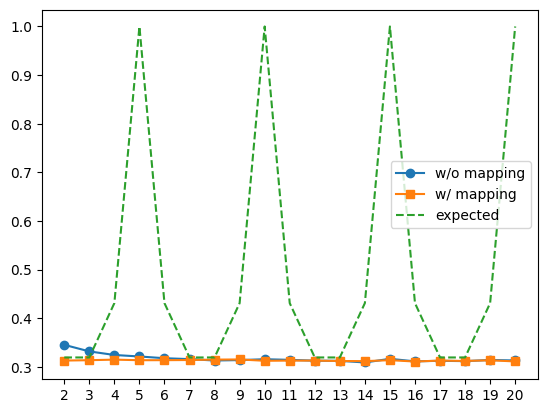

{'name': 'mapping effect, QFA state number effect', 'qfa size': 12, 'qiskit circuit size': 4, 'simulator': True, 'mimic_rate': 1, 'use_entropy_mapping': False, 'use_mapping_noise_correction': False}
{'name': 'mapping effect, QFA state number effect', 'qfa size': 12, 'qiskit circuit size': 4, 'simulator': True, 'mimic_rate': 1, 'use_entropy_mapping': True, 'use_mapping_noise_correction': False}


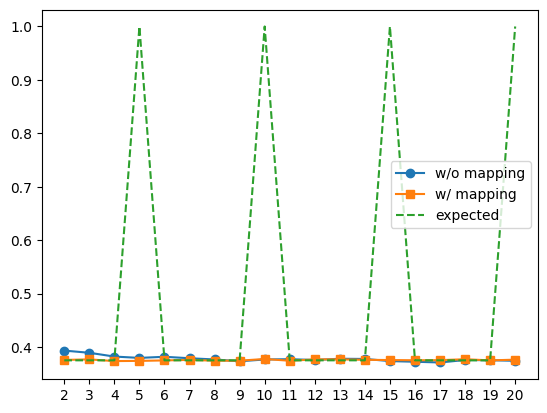

{'name': 'mapping effect, QFA state number effect', 'qfa size': 14, 'qiskit circuit size': 4, 'simulator': True, 'mimic_rate': 1, 'use_entropy_mapping': False, 'use_mapping_noise_correction': False}
{'name': 'mapping effect, QFA state number effect', 'qfa size': 14, 'qiskit circuit size': 4, 'simulator': True, 'mimic_rate': 1, 'use_entropy_mapping': True, 'use_mapping_noise_correction': False}


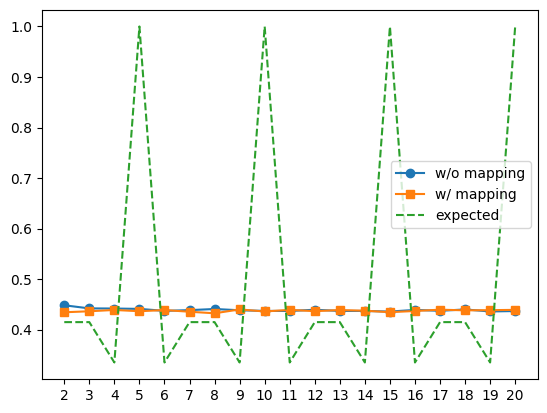

{'name': 'mapping effect, QFA state number effect', 'qfa size': 16, 'qiskit circuit size': 4, 'simulator': True, 'mimic_rate': 1, 'use_entropy_mapping': False, 'use_mapping_noise_correction': False}
{'name': 'mapping effect, QFA state number effect', 'qfa size': 16, 'qiskit circuit size': 4, 'simulator': True, 'mimic_rate': 1, 'use_entropy_mapping': True, 'use_mapping_noise_correction': False}


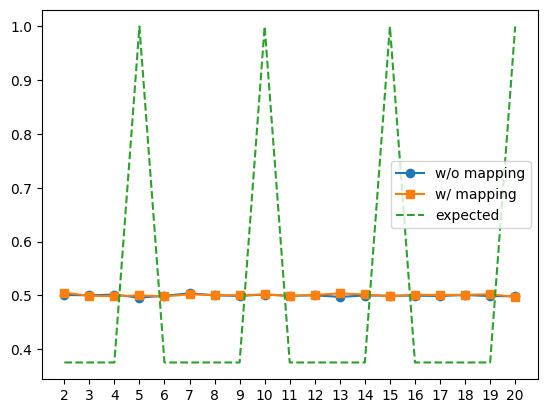

{'name': 'mapping effect, QFA state number effect', 'qfa size': 18, 'qiskit circuit size': 5, 'simulator': True, 'mimic_rate': 1, 'use_entropy_mapping': False, 'use_mapping_noise_correction': False}
{'name': 'mapping effect, QFA state number effect', 'qfa size': 18, 'qiskit circuit size': 5, 'simulator': True, 'mimic_rate': 1, 'use_entropy_mapping': True, 'use_mapping_noise_correction': False}


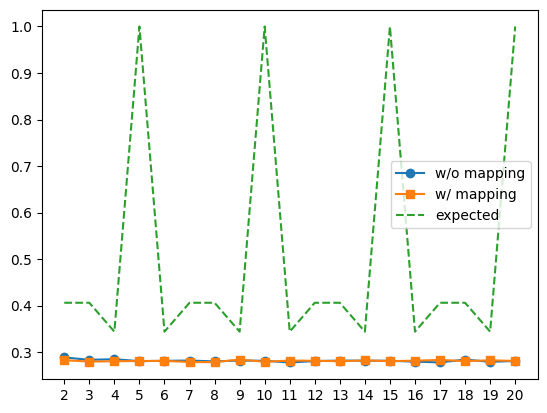

{'name': 'mapping effect, QFA state number effect', 'qfa size': 20, 'qiskit circuit size': 5, 'simulator': True, 'mimic_rate': 1, 'use_entropy_mapping': False, 'use_mapping_noise_correction': False}
{'name': 'mapping effect, QFA state number effect', 'qfa size': 20, 'qiskit circuit size': 5, 'simulator': True, 'mimic_rate': 1, 'use_entropy_mapping': True, 'use_mapping_noise_correction': False}


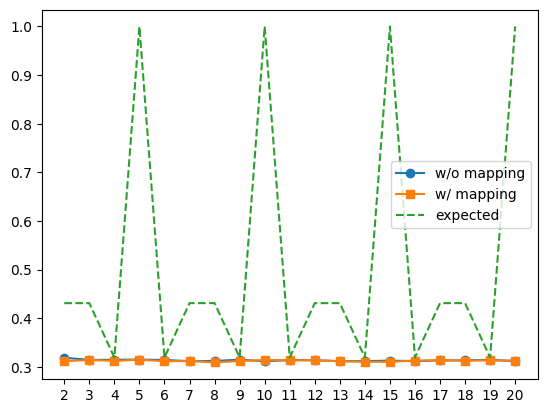

{'name': 'mapping effect, QFA state number effect', 'qfa size': 22, 'qiskit circuit size': 5, 'simulator': True, 'mimic_rate': 1, 'use_entropy_mapping': False, 'use_mapping_noise_correction': False}
{'name': 'mapping effect, QFA state number effect', 'qfa size': 22, 'qiskit circuit size': 5, 'simulator': True, 'mimic_rate': 1, 'use_entropy_mapping': True, 'use_mapping_noise_correction': False}


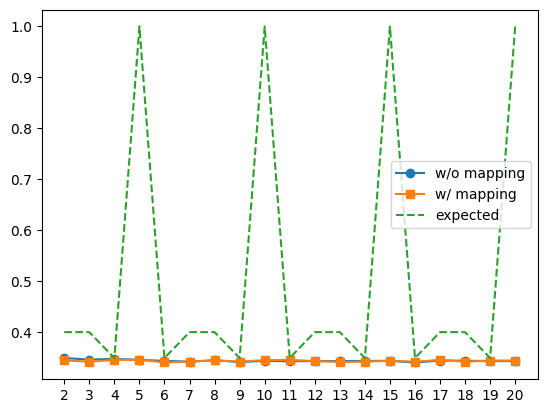

{'name': 'mapping effect, QFA state number effect', 'qfa size': 24, 'qiskit circuit size': 5, 'simulator': True, 'mimic_rate': 1, 'use_entropy_mapping': False, 'use_mapping_noise_correction': False}
{'name': 'mapping effect, QFA state number effect', 'qfa size': 24, 'qiskit circuit size': 5, 'simulator': True, 'mimic_rate': 1, 'use_entropy_mapping': True, 'use_mapping_noise_correction': False}


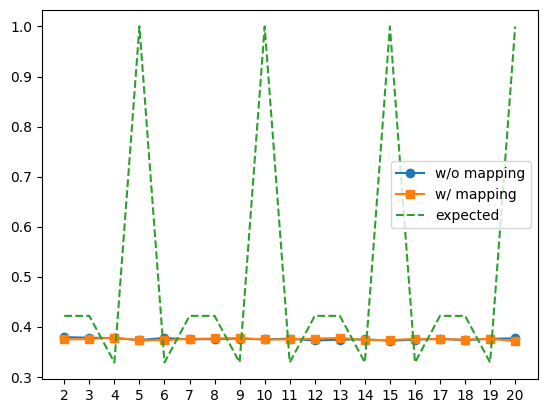

{'name': 'mapping effect, mimic rate {mimic_rate}', 'qfa size': 18, 'qiskit circuit size': 5, 'simulator': True, 'mimic_rate': 0.01, 'use_entropy_mapping': False, 'use_mapping_noise_correction': False}
{'name': 'mapping effect, mimic rate {mimic_rate}', 'qfa size': 18, 'qiskit circuit size': 5, 'simulator': True, 'mimic_rate': 0.01, 'use_entropy_mapping': True, 'use_mapping_noise_correction': False}


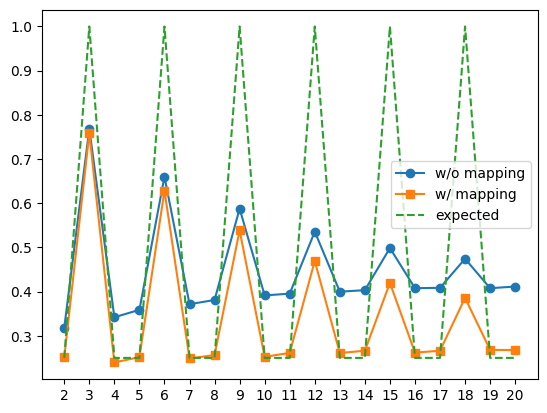

{'name': 'mapping effect, mimic rate {mimic_rate}', 'qfa size': 18, 'qiskit circuit size': 5, 'simulator': True, 'mimic_rate': 0.005, 'use_entropy_mapping': False, 'use_mapping_noise_correction': False}
{'name': 'mapping effect, mimic rate {mimic_rate}', 'qfa size': 18, 'qiskit circuit size': 5, 'simulator': True, 'mimic_rate': 0.005, 'use_entropy_mapping': True, 'use_mapping_noise_correction': False}


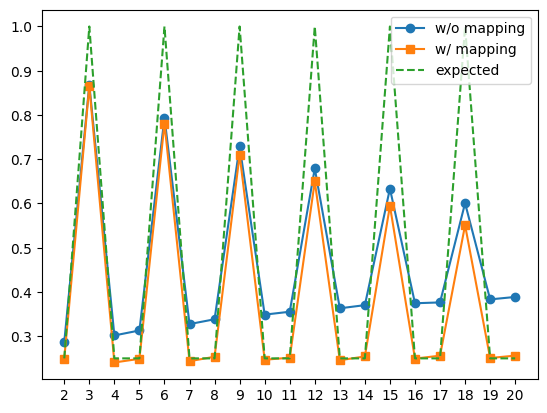

{'name': 'mapping effect, mimic rate {mimic_rate}', 'qfa size': 18, 'qiskit circuit size': 5, 'simulator': True, 'mimic_rate': 0.001, 'use_entropy_mapping': False, 'use_mapping_noise_correction': False}
{'name': 'mapping effect, mimic rate {mimic_rate}', 'qfa size': 18, 'qiskit circuit size': 5, 'simulator': True, 'mimic_rate': 0.001, 'use_entropy_mapping': True, 'use_mapping_noise_correction': False}


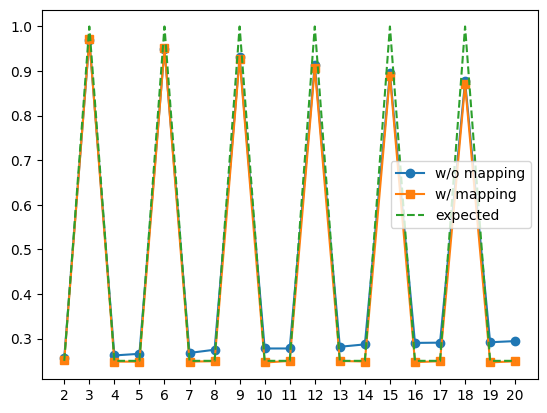

{'name': 'mapping effect, mimic rate {mimic_rate}', 'qfa size': 18, 'qiskit circuit size': 5, 'simulator': True, 'mimic_rate': 0.0005, 'use_entropy_mapping': False, 'use_mapping_noise_correction': False}
{'name': 'mapping effect, mimic rate {mimic_rate}', 'qfa size': 18, 'qiskit circuit size': 5, 'simulator': True, 'mimic_rate': 0.0005, 'use_entropy_mapping': True, 'use_mapping_noise_correction': False}


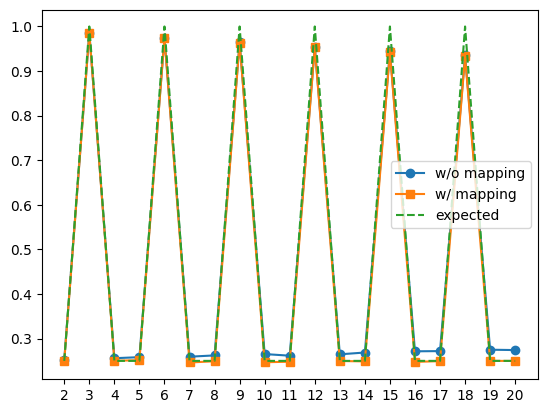

{'name': 'mapping effect, mimic rate {mimic_rate}', 'qfa size': 18, 'qiskit circuit size': 5, 'simulator': True, 'mimic_rate': 0, 'use_entropy_mapping': False, 'use_mapping_noise_correction': False}
{'name': 'mapping effect, mimic rate {mimic_rate}', 'qfa size': 18, 'qiskit circuit size': 5, 'simulator': True, 'mimic_rate': 0, 'use_entropy_mapping': True, 'use_mapping_noise_correction': False}


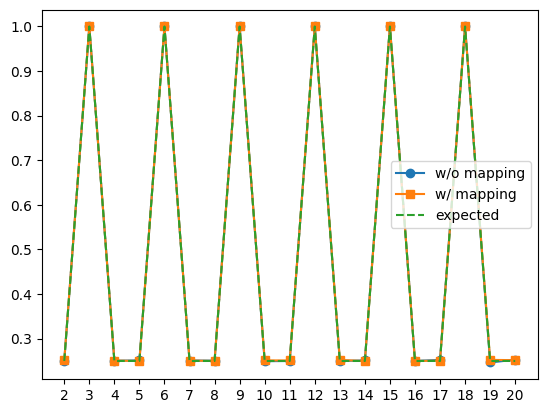

{'name': 'mapping effect, mimic rate {mimic_rate}', 'qfa size': 26, 'qiskit circuit size': 5, 'simulator': True, 'mimic_rate': 0.01, 'use_entropy_mapping': False, 'use_mapping_noise_correction': False}
{'name': 'mapping effect, mimic rate {mimic_rate}', 'qfa size': 26, 'qiskit circuit size': 5, 'simulator': True, 'mimic_rate': 0.01, 'use_entropy_mapping': True, 'use_mapping_noise_correction': False}


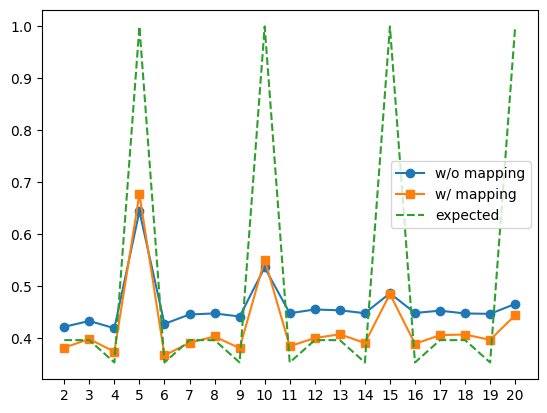

{'name': 'mapping effect, mimic rate {mimic_rate}', 'qfa size': 26, 'qiskit circuit size': 5, 'simulator': True, 'mimic_rate': 0.005, 'use_entropy_mapping': False, 'use_mapping_noise_correction': False}
{'name': 'mapping effect, mimic rate {mimic_rate}', 'qfa size': 26, 'qiskit circuit size': 5, 'simulator': True, 'mimic_rate': 0.005, 'use_entropy_mapping': True, 'use_mapping_noise_correction': False}


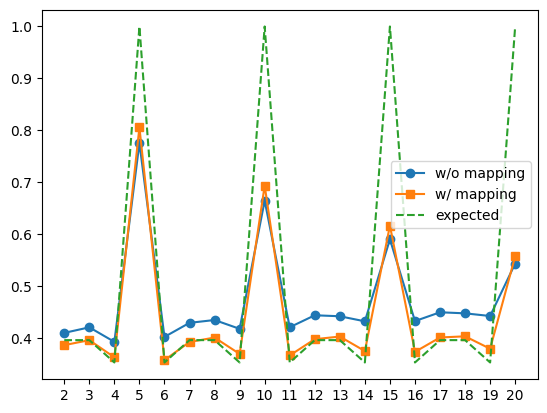

{'name': 'mapping effect, mimic rate {mimic_rate}', 'qfa size': 26, 'qiskit circuit size': 5, 'simulator': True, 'mimic_rate': 0.001, 'use_entropy_mapping': False, 'use_mapping_noise_correction': False}
{'name': 'mapping effect, mimic rate {mimic_rate}', 'qfa size': 26, 'qiskit circuit size': 5, 'simulator': True, 'mimic_rate': 0.001, 'use_entropy_mapping': True, 'use_mapping_noise_correction': False}


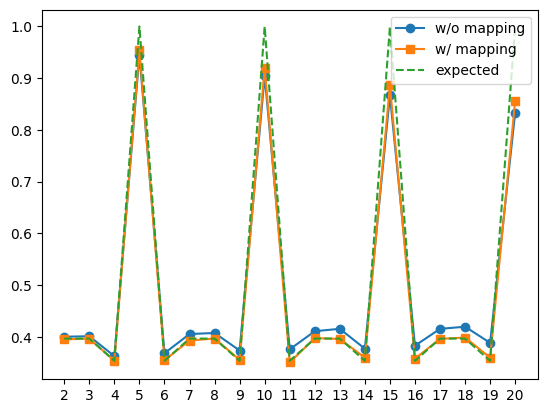

{'name': 'mapping effect, mimic rate {mimic_rate}', 'qfa size': 26, 'qiskit circuit size': 5, 'simulator': True, 'mimic_rate': 0.0005, 'use_entropy_mapping': False, 'use_mapping_noise_correction': False}
{'name': 'mapping effect, mimic rate {mimic_rate}', 'qfa size': 26, 'qiskit circuit size': 5, 'simulator': True, 'mimic_rate': 0.0005, 'use_entropy_mapping': True, 'use_mapping_noise_correction': False}


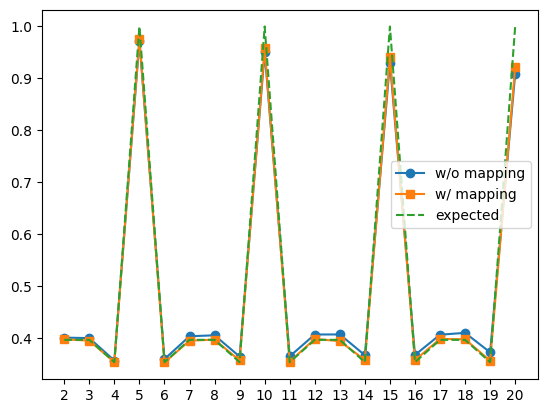

{'name': 'mapping effect, mimic rate {mimic_rate}', 'qfa size': 26, 'qiskit circuit size': 5, 'simulator': True, 'mimic_rate': 0, 'use_entropy_mapping': False, 'use_mapping_noise_correction': False}
{'name': 'mapping effect, mimic rate {mimic_rate}', 'qfa size': 26, 'qiskit circuit size': 5, 'simulator': True, 'mimic_rate': 0, 'use_entropy_mapping': True, 'use_mapping_noise_correction': False}


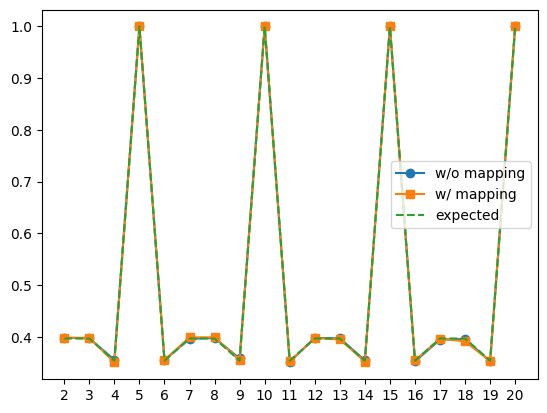

{'name': 'mapping effect, mimic rate {mimic_rate}', 'qfa size': 32, 'qiskit circuit size': 5, 'simulator': True, 'mimic_rate': 0.01, 'use_entropy_mapping': False, 'use_mapping_noise_correction': False}
{'name': 'mapping effect, mimic rate {mimic_rate}', 'qfa size': 32, 'qiskit circuit size': 5, 'simulator': True, 'mimic_rate': 0.01, 'use_entropy_mapping': True, 'use_mapping_noise_correction': False}


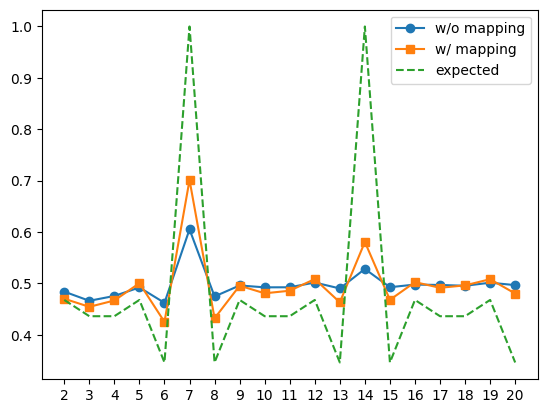

{'name': 'mapping effect, mimic rate {mimic_rate}', 'qfa size': 32, 'qiskit circuit size': 5, 'simulator': True, 'mimic_rate': 0.005, 'use_entropy_mapping': False, 'use_mapping_noise_correction': False}
{'name': 'mapping effect, mimic rate {mimic_rate}', 'qfa size': 32, 'qiskit circuit size': 5, 'simulator': True, 'mimic_rate': 0.005, 'use_entropy_mapping': True, 'use_mapping_noise_correction': False}


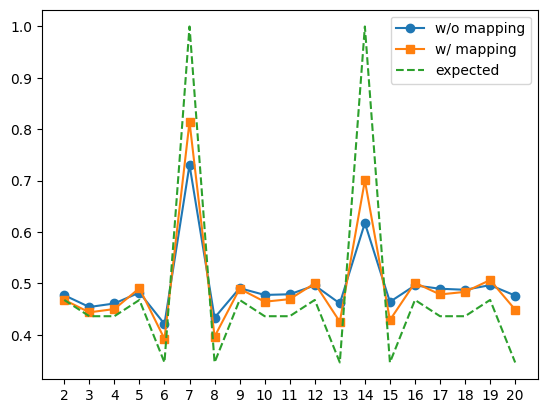

{'name': 'mapping effect, mimic rate {mimic_rate}', 'qfa size': 32, 'qiskit circuit size': 5, 'simulator': True, 'mimic_rate': 0.001, 'use_entropy_mapping': False, 'use_mapping_noise_correction': False}
{'name': 'mapping effect, mimic rate {mimic_rate}', 'qfa size': 32, 'qiskit circuit size': 5, 'simulator': True, 'mimic_rate': 0.001, 'use_entropy_mapping': True, 'use_mapping_noise_correction': False}


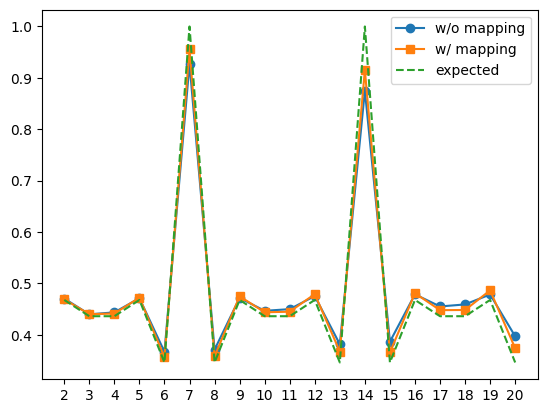

{'name': 'mapping effect, mimic rate {mimic_rate}', 'qfa size': 32, 'qiskit circuit size': 5, 'simulator': True, 'mimic_rate': 0.0005, 'use_entropy_mapping': False, 'use_mapping_noise_correction': False}
{'name': 'mapping effect, mimic rate {mimic_rate}', 'qfa size': 32, 'qiskit circuit size': 5, 'simulator': True, 'mimic_rate': 0.0005, 'use_entropy_mapping': True, 'use_mapping_noise_correction': False}


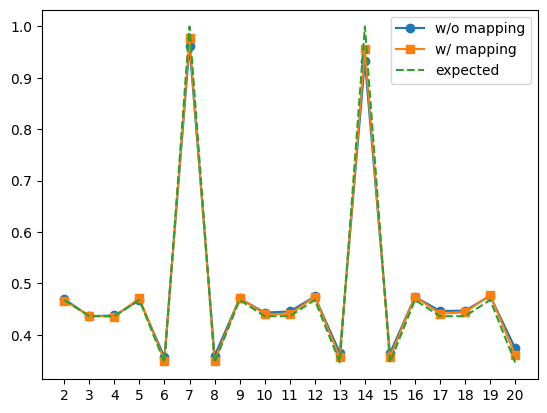

{'name': 'mapping effect, mimic rate {mimic_rate}', 'qfa size': 32, 'qiskit circuit size': 5, 'simulator': True, 'mimic_rate': 0, 'use_entropy_mapping': False, 'use_mapping_noise_correction': False}
{'name': 'mapping effect, mimic rate {mimic_rate}', 'qfa size': 32, 'qiskit circuit size': 5, 'simulator': True, 'mimic_rate': 0, 'use_entropy_mapping': True, 'use_mapping_noise_correction': False}


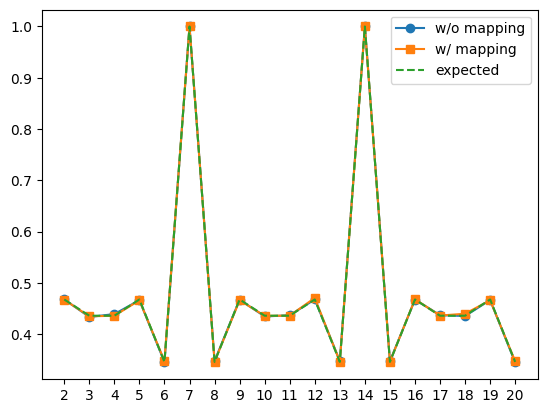

{'name': 'mapping effect, mimic rate {mimic_rate}', 'qfa size': 40, 'qiskit circuit size': 6, 'simulator': True, 'mimic_rate': 0.01, 'use_entropy_mapping': False, 'use_mapping_noise_correction': False}
{'name': 'mapping effect, mimic rate {mimic_rate}', 'qfa size': 40, 'qiskit circuit size': 6, 'simulator': True, 'mimic_rate': 0.01, 'use_entropy_mapping': True, 'use_mapping_noise_correction': False}


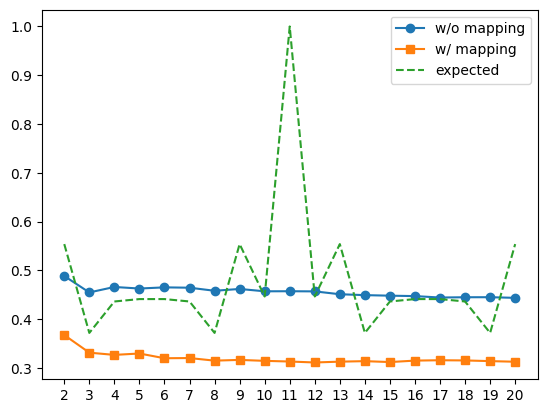

{'name': 'mapping effect, mimic rate {mimic_rate}', 'qfa size': 40, 'qiskit circuit size': 6, 'simulator': True, 'mimic_rate': 0.005, 'use_entropy_mapping': False, 'use_mapping_noise_correction': False}
{'name': 'mapping effect, mimic rate {mimic_rate}', 'qfa size': 40, 'qiskit circuit size': 6, 'simulator': True, 'mimic_rate': 0.005, 'use_entropy_mapping': True, 'use_mapping_noise_correction': False}


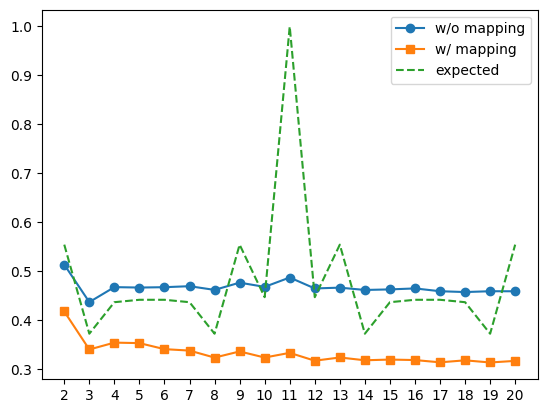

{'name': 'mapping effect, mimic rate {mimic_rate}', 'qfa size': 40, 'qiskit circuit size': 6, 'simulator': True, 'mimic_rate': 0.001, 'use_entropy_mapping': False, 'use_mapping_noise_correction': False}
{'name': 'mapping effect, mimic rate {mimic_rate}', 'qfa size': 40, 'qiskit circuit size': 6, 'simulator': True, 'mimic_rate': 0.001, 'use_entropy_mapping': True, 'use_mapping_noise_correction': False}


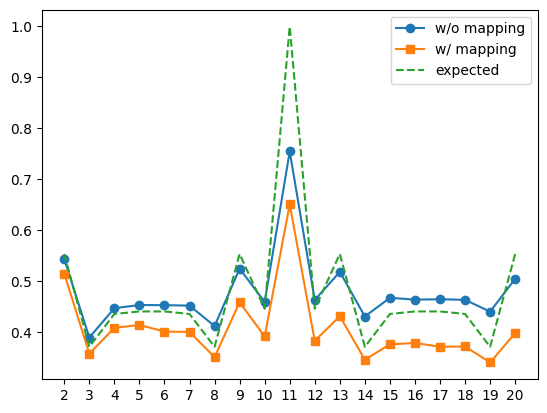

{'name': 'mapping effect, mimic rate {mimic_rate}', 'qfa size': 40, 'qiskit circuit size': 6, 'simulator': True, 'mimic_rate': 0.0005, 'use_entropy_mapping': False, 'use_mapping_noise_correction': False}
{'name': 'mapping effect, mimic rate {mimic_rate}', 'qfa size': 40, 'qiskit circuit size': 6, 'simulator': True, 'mimic_rate': 0.0005, 'use_entropy_mapping': True, 'use_mapping_noise_correction': False}


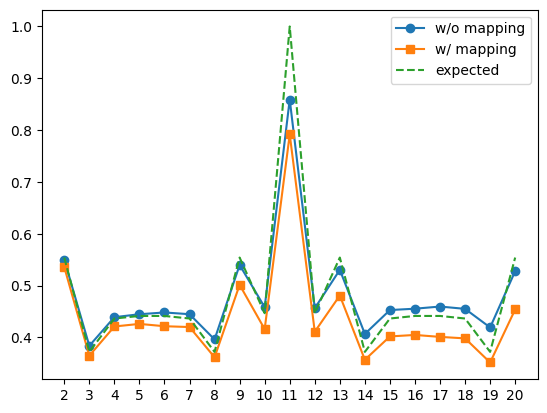

{'name': 'mapping effect, mimic rate {mimic_rate}', 'qfa size': 40, 'qiskit circuit size': 6, 'simulator': True, 'mimic_rate': 0, 'use_entropy_mapping': False, 'use_mapping_noise_correction': False}
{'name': 'mapping effect, mimic rate {mimic_rate}', 'qfa size': 40, 'qiskit circuit size': 6, 'simulator': True, 'mimic_rate': 0, 'use_entropy_mapping': True, 'use_mapping_noise_correction': False}


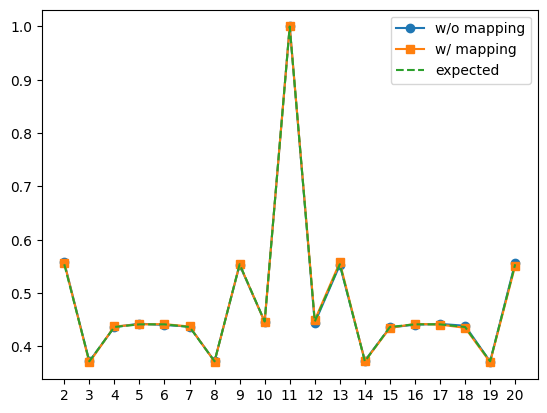

{'name': 'mapping effect, mimic rate {mimic_rate}', 'qfa size': 4, 'qiskit circuit size': 2, 'simulator': True, 'mimic_rate': 0.01, 'use_entropy_mapping': False, 'use_mapping_noise_correction': False}
{'name': 'mapping effect, mimic rate {mimic_rate}', 'qfa size': 4, 'qiskit circuit size': 2, 'simulator': True, 'mimic_rate': 0.01, 'use_entropy_mapping': True, 'use_mapping_noise_correction': False}


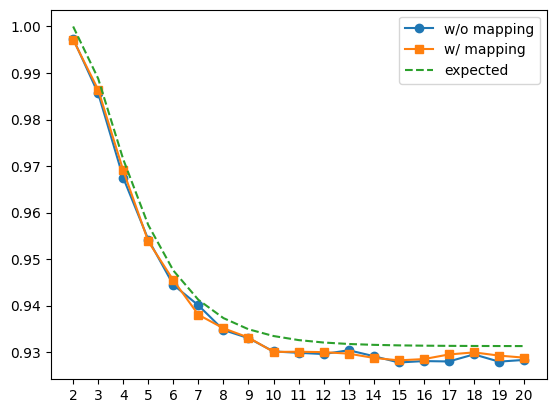

{'name': 'mapping effect, mimic rate {mimic_rate}', 'qfa size': 4, 'qiskit circuit size': 2, 'simulator': True, 'mimic_rate': 0.005, 'use_entropy_mapping': False, 'use_mapping_noise_correction': False}
{'name': 'mapping effect, mimic rate {mimic_rate}', 'qfa size': 4, 'qiskit circuit size': 2, 'simulator': True, 'mimic_rate': 0.005, 'use_entropy_mapping': True, 'use_mapping_noise_correction': False}


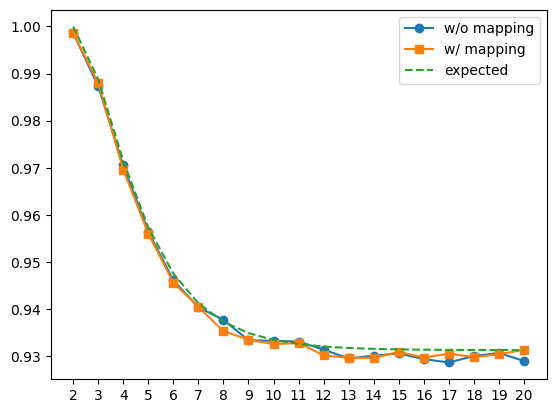

{'name': 'mapping effect, mimic rate {mimic_rate}', 'qfa size': 4, 'qiskit circuit size': 2, 'simulator': True, 'mimic_rate': 0.001, 'use_entropy_mapping': False, 'use_mapping_noise_correction': False}
{'name': 'mapping effect, mimic rate {mimic_rate}', 'qfa size': 4, 'qiskit circuit size': 2, 'simulator': True, 'mimic_rate': 0.001, 'use_entropy_mapping': True, 'use_mapping_noise_correction': False}


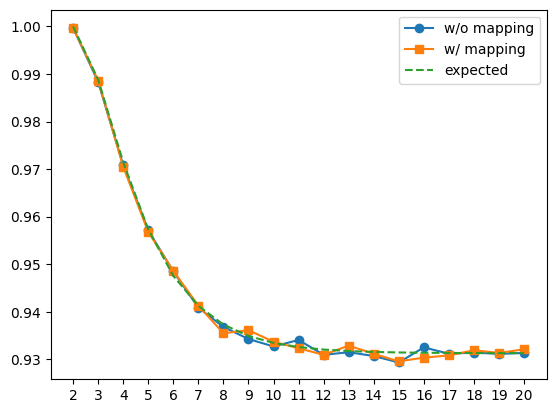

{'name': 'mapping effect, mimic rate {mimic_rate}', 'qfa size': 4, 'qiskit circuit size': 2, 'simulator': True, 'mimic_rate': 0.0005, 'use_entropy_mapping': False, 'use_mapping_noise_correction': False}
{'name': 'mapping effect, mimic rate {mimic_rate}', 'qfa size': 4, 'qiskit circuit size': 2, 'simulator': True, 'mimic_rate': 0.0005, 'use_entropy_mapping': True, 'use_mapping_noise_correction': False}


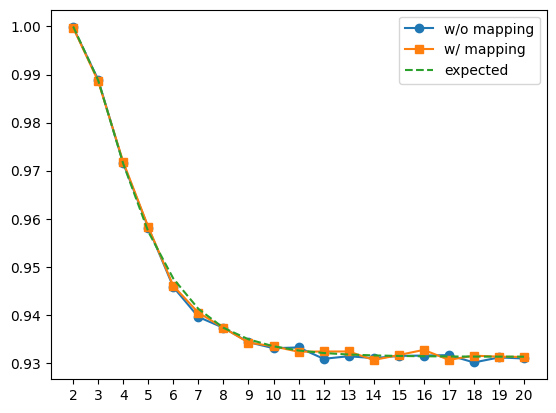

{'name': 'mapping effect, mimic rate {mimic_rate}', 'qfa size': 4, 'qiskit circuit size': 2, 'simulator': True, 'mimic_rate': 0, 'use_entropy_mapping': False, 'use_mapping_noise_correction': False}
{'name': 'mapping effect, mimic rate {mimic_rate}', 'qfa size': 4, 'qiskit circuit size': 2, 'simulator': True, 'mimic_rate': 0, 'use_entropy_mapping': True, 'use_mapping_noise_correction': False}


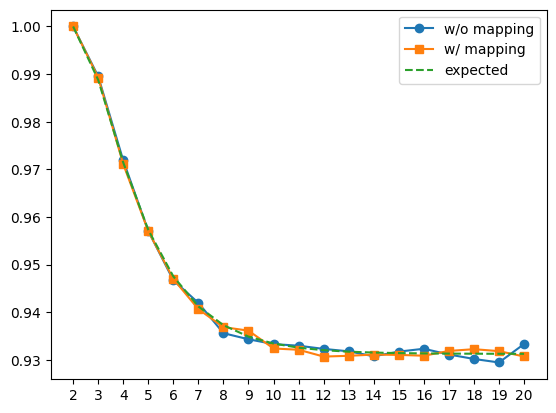

In [44]:
for k, experiment in iterate_nested_dict(experiments):
    if k['use_entropy_mapping']:
        continue
    k_ = k.copy()
    k_['use_entropy_mapping'] = True
    experiment2 = get_from_nested_dict(experiments, k_)
    print(k)
    print(k_)
    draw_comparison_plot(experiment, experiment2, ["w/o mapping", "w/ mapping"])